## Library imports

All the libraries used should be installed by default in instances of Jupyter Notebook

In [1]:
import pandas as pd

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import reset_ramsey
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import itertools
import warnings


## Data Loading & Exploratory Analyses

In [2]:
# Load the data
data = pd.read_csv("data.csv")

In [3]:
# Check the first few rows of the dataset
print("Data head:\n", data.head(),'\n')

# Check the dimensions of the dataset
print("Shape:", data.shape,'\n')

# Check the data types of each column
print("Data types\n", data.dtypes, '\n')

# Check descriptive statistic data
print("Details\n", data.describe())

Data head:
          Date  EU_CPIYOY  EU_GDPYOY   EURIBOR  GDPYOY      INFL   ROBOR3M  \
0   3/31/2002   0.025591   0.004074  0.033615   0.035  0.269667  0.361300   
1   6/30/2002   0.021117   0.008838  0.034461   0.058  0.243000  0.330400   
2   9/30/2002   0.021061   0.011552  0.033589   0.054  0.213667  0.277433   
3  12/31/2002   0.022949   0.012011  0.031162   0.055  0.184000  0.224567   
4   3/31/2003   0.023215   0.007951  0.026854   0.052  0.166667  0.191867   

   LT_IR    EURRON  ROKEPOLA  LENDRATE  DEPRATE     UNEMP  DR_12  
0    NaN  2.852567       NaN       NaN      NaN  0.132000    NaN  
1    NaN  3.031700       NaN       NaN      NaN  0.106000    NaN  
2    NaN  3.237633       NaN       NaN      NaN  0.087667    NaN  
3    NaN  3.362967       NaN       NaN      NaN  0.082333    NaN  
4    NaN  3.543667  0.191567       NaN      NaN  0.086667    NaN   

Shape: (84, 14) 

Data types
 Date          object
EU_CPIYOY    float64
EU_GDPYOY    float64
EURIBOR      float64
GDPYOY 

In [4]:
# Compute correlation matrix
correlation_matrix = data.corr()
print(correlation_matrix)

           EU_CPIYOY  EU_GDPYOY   EURIBOR    GDPYOY      INFL   ROBOR3M  \
EU_CPIYOY   1.000000   0.547262  0.231320  0.285746  0.506301  0.163031   
EU_GDPYOY   0.547262   1.000000 -0.031618  0.616312  0.125983 -0.131889   
EURIBOR     0.231320  -0.031618  1.000000  0.350627  0.537372  0.668435   
GDPYOY      0.285746   0.616312  0.350627  1.000000  0.153192  0.147985   
INFL        0.506301   0.125983  0.537372  0.153192  1.000000  0.867852   
ROBOR3M     0.163031  -0.131889  0.668435  0.147985  0.867852  1.000000   
LT_IR       0.334442  -0.241204  0.690442 -0.294560  0.610469  0.938756   
EURRON      0.041478   0.100194 -0.883582 -0.275998 -0.522574 -0.703184   
ROKEPOLA    0.121477  -0.112168  0.638142  0.184228  0.738596  0.970766   
LENDRATE    0.058630  -0.384423  0.695625 -0.260130  0.392407  0.944393   
DEPRATE     0.194838  -0.313046  0.724578 -0.246787  0.512704  0.978561   
UNEMP      -0.190690  -0.188754  0.383485 -0.116684  0.571710  0.743799   
DR_12       0.422219  -0.

Based on this correlation matrix, we can observe some of the following variables with relatively high correlation coefficients:

    INFL and ROBOR3M: 0.867852 (high positive correlation)
    INFL and LT_IR: 0.738756 (high positive correlation)
    INFL and ROKEPOLA: 0.738596 (high positive correlation)
    ROBOR3M and LT_IR: 0.938756 (high positive correlation)
    ROBOR3M and ROKEPOLA: 0.970766 (high positive correlation)
    LT_IR and ROKEPOLA: 0.942192 (high positive correlation)
    LENDRATE and DEPRATE: 0.973802 (high positive correlation)
    EURIBOR and EURRON: -0.883582 (high negative correlation)

In [5]:
# Convert the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as index
data.set_index('Date', inplace=True)

The data has been successfully loaded, and the 'Date' column has been converted to a datetime format. 

Now, let's proceed to the data preprocessing stage and create the sample data sets.

> Development sample: 2008 – 2018; Validation sample: 2019 – 2021; Test sample: year 2022

In [6]:
# Split the data based on time periods
dev_start = pd.to_datetime('2008-01-01')
dev_end = pd.to_datetime('2018-12-31')
val_start = pd.to_datetime('2019-01-01')
val_end = pd.to_datetime('2021-12-31')
test_start = pd.to_datetime('2022-01-01')
test_end = pd.to_datetime('2022-12-31')

# Development sample
development_data = data.loc[(data.index >= dev_start) & (data.index <= dev_end)]

# Validation sample
validation_data = data.loc[(data.index >= val_start) & (data.index <= val_end)]

# Test sample
testing_data = data.loc[(data.index >= test_start) & (data.index <= test_end)]

print(validation_data.shape)
print(development_data.shape)
print(testing_data.shape)

(12, 13)
(44, 13)
(4, 13)


We have successfully created the development, validation, and test datasets.

Now, Let's move on to the first model.

## Model #1

Multiple Linear Regression

Next, let's build the multiple linear regression model using the development dataset.

The 'DR_12', 'EU_CPIYOY', 'EU_GDPYOY', and 'EURIBOR' columns will be the focus of our analysis.

In [7]:
# Define the independent and dependent variables
independent_vars = ['EU_CPIYOY', 'EU_GDPYOY', 'EURIBOR']
dependent_var = 'DR_12'

# Add a constant term to the independent variables
X = sm.add_constant(development_data[independent_vars])

# Create the linear regression model
model = sm.OLS(development_data[dependent_var], X)

# Fit the model to the data
results = model.fit()

# Print the regression summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  DR_12   R-squared:                       0.597
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     19.73
Date:                Sun, 16 Jul 2023   Prob (F-statistic):           5.22e-08
Time:                        20:35:30   Log-Likelihood:                 147.02
No. Observations:                  44   AIC:                            -286.0
Df Residuals:                      40   BIC:                            -278.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0187      0.002      8.040      0.0

### R^2 (passed)
The R-squared value is 0.597, which suggests that around 59.7% of the variation in the dependent variable ('DR_12') can be explained by the independent variables 'EU_CPIYOY', 'EU_GDPYOY', and 'EURIBOR'.

### P-Values (passed)
The p-values for the coefficients of 'EU_CPIYOY', 'EU_GDPYOY', and 'EURIBOR' are all less than 0.05, indicating that these variables are statistically significant in predicting 'DR_12'.

### Durbin-Watson (failed)
The Durbin-Watson statistic is 0.615, which indicates the presence of positive autocorrelation.

In our case, the positive autocorrelation could be due to such temporal dependencies in the macroeconomic variables we're using to predict the default rate. For example, the EU GDP growth rate (EU_GDPYOY) and the EU InterBank Offered Rate (EURIBOR) could exhibit trends or cycles over time, leading to positive autocorrelation in these variables and consequently in the residuals of the regression model.

While the presence of autocorrelation violates the assumptions of the linear regression model, it doesn't necessarily mean that the predictions of the model are inaccurate. However, the hypothesis tests and confidence intervals that rely on these standard errors could be misleading.

In [8]:
X_val = sm.add_constant(validation_data[independent_vars])

# Predict the values using the trained model
predicted_values = results.predict(X_val)

# Get the actual values from the validation sample
actual_values = validation_data['DR_12']

# Print the predicted, actual, and delta values
result_df = pd.DataFrame({'Predicted': predicted_values, 'Actual': actual_values})
print(result_df)



            Predicted    Actual
Date                           
2019-03-31   0.031877  0.023989
2019-06-30   0.032649  0.024654
2019-09-30   0.027467  0.024674
2019-12-31   0.029354  0.023113
2020-03-31   0.045593  0.022643
2020-06-30   0.067442  0.019986
2020-09-30   0.028329  0.017640
2020-12-31   0.026731  0.017834
2021-03-31   0.034466  0.017606
2021-06-30  -0.011471  0.017742
2021-09-30   0.036389  0.018682
2021-12-31   0.052783  0.019363


In [9]:
print("RMSE:", sm.tools.eval_measures.rmse(predicted_values, actual_values, axis=0))

RMSE: 0.0218197100755919


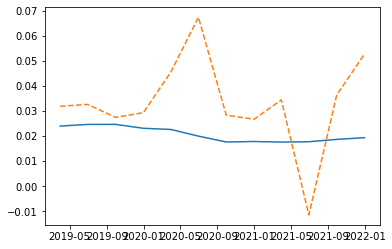

In [10]:
plt.plot(result_df['Actual'], label='Actual')
plt.plot(result_df['Predicted'], label='Predicted',linestyle='--')
plt.show()

While the predictions don't deviate much, we got negative results for the DR, which is not possible.

The overall RMSE for this model is 0.0218197100755919

In [11]:
X_val_test = sm.add_constant(testing_data[independent_vars])

# Predict the values using the trained model
predicted_values_test = results.predict(X_val_test)

# Get the actual values from the validation sample
actual_values = validation_data['DR_12']

# Print the predicted, actual, and delta values
result_df_test = pd.DataFrame({'Predicted': predicted_values_test})
print(result_df_test)

            Predicted
Date                 
2022-03-31   0.073960
2022-06-30   0.088684
2022-09-30   0.103253
2022-12-31   0.087955


Predicted values for the test sample are:

    2022-03-31   0.073960
    2022-06-30   0.088684
    2022-09-30   0.103253
    2022-12-31   0.087955

### Stationarity test
Augmented Dickey-Fuller (for the dependent variable and each independent variable)

In [12]:
# Initialize a dictionary to store the test results
adf_results = {}

# Perform the Augmented Dickey-Fuller test for the dependent variable and each independent variable
for column in ['DR_12', 'EU_CPIYOY', 'EU_GDPYOY', 'EURIBOR']:
    adf_test = adfuller(development_data[column])
    print(column,':', adf_test)

DR_12 : (-1.6113348180051068, 0.4772749426913591, 0, 43, {'1%': -3.5925042342183704, '5%': -2.931549768951162, '10%': -2.60406594375338}, -228.99785748802475)
EU_CPIYOY : (-1.409817729446601, 0.5775604303674332, 8, 35, {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}, -280.8761783647124)
EU_GDPYOY : (-0.7883121916083635, 0.8225311875479389, 9, 34, {'1%': -3.639224104416853, '5%': -2.9512301791166293, '10%': -2.614446989619377}, -279.6905583957474)
EURIBOR : (-3.959549196685261, 0.0016377816643213447, 10, 33, {'1%': -3.6461350877925254, '5%': -2.954126991123355, '10%': -2.6159676124885216}, -391.5265683848823)


The results of the Augmented Dickey-Fuller (ADF) test for stationarity are as follows:

    'DR_12': The p-value is 0.48, which is greater than 0.05. This means we cannot reject the null hypothesis of the ADF test, implying that the 'DR_12' series is non-stationary.
    'EU_CPIYOY': The p-value is 0.58, which is greater than 0.05. This means we cannot reject the null hypothesis of the ADF test, implying that the 'EU_CPIYOY' series is non-stationary.
    'EU_GDPYOY': The p-value is 0.82, which is greater than 0.05. This means we cannot reject the null hypothesis of the ADF test, implying that the 'EU_GDPYOY' series is non-stationary.
    'EURIBOR': The p-value is 0.0016, which is less than 0.05. This means we can reject the null hypothesis of the ADF test, implying that the 'EURIBOR' series is stationary.

The non-stationarity of 'DR_12', 'EU_CPIYOY', and 'EU_GDPYOY' could be a potential issue for our linear regression model, as it assumes that the data is stationary.

### Multicollinearity test
Variance Inflation Factor (VIF)

In [13]:
# Calculate the VIF for each independent variable
vif = pd.DataFrame()
vif["Variable"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print the VIF values
print(vif)

    Variable       VIF
0      const  2.940369
1  EU_CPIYOY  1.860373
2  EU_GDPYOY  1.228875
3    EURIBOR  2.003400


Variance Inflation Factor (VIF): All the VIFs are less than 10 (1.86 for 'EU_CPIYOY', 1.22 for 'EU_GDPYOY', and 2 for 'EURIBOR'). This suggests that there is no severe multicollinearity among the independent variables.

### Heteroscedasticity
Breusch Pagan

In [14]:
# Get the residuals of the model
residuals = results.resid

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(residuals, results.model.exog)

bp_test

(20.231469683110117,
 0.00015198772995010548,
 11.34916317970442,
 1.603052026578859e-05)

The p-value of the test is 0.00015, which is less than 0.05. This means we can reject the null hypothesis of the test, implying that the data is heteroscedastic (the error variances are not equal).

### Normality of residuals
Shapiro-Wilk

In [15]:
# Perform the Shapiro-Wilk test
shapiro_test = shapiro(residuals)

shapiro_test

ShapiroResult(statistic=0.9829384684562683, pvalue=0.7510119080543518)

The p-value of the test is 0.75, which is greater than 0.05. This means we cannot reject the null hypothesis of the test, implying that the residuals are normally distributed.

### Functional form test
Ramsey

In [16]:
# Perform the Ramsey RESET test
reset_test = reset_ramsey(results, degree=5)

reset_test

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=8.840904790123915, p=4.439783898436391e-05, df_denom=36, df_num=4>

The p-value of the test is 0.0000444, which is less than 0.05. This means we can reject the null hypothesis of the test, implying that the model might be misspecified. The diagnostic tests suggest that the model might have some issues.

## Model #2

Random Forest

In [17]:
# Split the data into features and target variables
X_dev = development_data.drop(columns='DR_12')
y_dev = development_data['DR_12']

X_val = validation_data.drop(columns='DR_12')
y_val = validation_data['DR_12']

X_test = testing_data.drop(columns='DR_12')

# Train a random forest regressor
rf = RandomForestRegressor(random_state=42)

rf.fit(X_dev, y_dev)

# Predict on the validation and test sets
y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

# Calculate the root mean squared error for the validation set
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)

# Prepare the results for plotting
val_results = pd.DataFrame({'Actual': y_val, 'Predicted': y_val_pred})
test_results = pd.DataFrame({'Predicted': y_test_pred}, index=X_test.index)

# Print the RMSE for the validation set
print("RMSE (Validation):", rmse_val)

print("\nValidation Results:")
print(val_results)

print("\nTest Results:")
print(test_results)


RMSE (Validation): 0.013285815359799334

Validation Results:
              Actual  Predicted
Date                           
2019-03-31  0.023989   0.023345
2019-06-30  0.024654   0.023798
2019-09-30  0.024674   0.022222
2019-12-31  0.023113   0.024691
2020-03-31  0.022643   0.031447
2020-06-30  0.019986   0.030563
2020-09-30  0.017640   0.029948
2020-12-31  0.017834   0.030362
2021-03-31  0.017606   0.023183
2021-06-30  0.017742   0.019232
2021-09-30  0.018682   0.045338
2021-12-31  0.019363   0.048805

Test Results:
            Predicted
Date                 
2022-03-31   0.046401
2022-06-30   0.045908
2022-09-30   0.043072
2022-12-31   0.043575


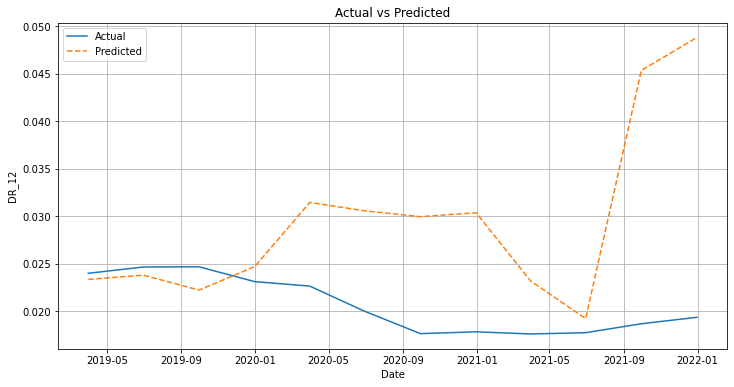

In [18]:
# Plot the actual vs predicted for validation data
plt.figure(figsize=(12, 6))
plt.plot(val_results.index, val_results['Actual'], label='Actual')
plt.plot(val_results.index, val_results['Predicted'], label='Predicted', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('DR_12')
plt.legend()
plt.grid(True)
plt.show()

The root mean squared error (RMSE) for the validation set is approximately 0.013285815359799334, which is better than the Linear Regression model.

The plot shows the actual versus predicted values for the 'DR_12' variable in the validation data from 2019 to 2021.

As you can see, the model seems to perform reasonably well on the validation data, with the predicted values closely following the trend of the actual values. 

For the test data in 2022, the model predicts a slight decrease in 'DR_12' towards the end of the year. The predictions are:

    2022-03-31   0.046401
    2022-06-30   0.045908
    2022-09-30   0.043072
    2022-12-31   0.043575

In [19]:
# Calculate the correlation matrix for the independent variables
correlation_matrix = X_dev.corr()

# Create a mask for highly correlated variables
high_corr_mask = abs(correlation_matrix) > 0.7

# Get the pairs of highly correlated variables
high_corr_pairs = [(i, j) for i in range(len(high_corr_mask)) for j in range(i+1, len(high_corr_mask)) if high_corr_mask.iloc[i, j]]

# Get the variable names for the highly correlated pairs
high_corr_vars = [(correlation_matrix.columns[i], correlation_matrix.columns[j]) for i, j in high_corr_pairs]

# Get the feature importances from the random forest model
feature_importances = rf.feature_importances_

# Get the variable importance
var_importance = pd.DataFrame({'Variable': X_dev.columns, 'Importance': feature_importances}).sort_values('Importance', ascending=False)

# Get the regression coefficients (feature importances in this case as Random Forest does not have coefficients)
coefficients = pd.Series(feature_importances, index=X_dev.columns)

# Check for variables where the sign of the regression coefficients might not be in line with business expectations
unexpected_signs = coefficients[(coefficients < 0)]

correlation_matrix, high_corr_vars, var_importance, unexpected_signs

(           EU_CPIYOY  EU_GDPYOY   EURIBOR    GDPYOY      INFL   ROBOR3M  \
 EU_CPIYOY   1.000000   0.082769  0.625146  0.323305  0.652315  0.411756   
 EU_GDPYOY   0.082769   1.000000 -0.278843  0.511498 -0.306232 -0.678784   
 EURIBOR     0.625146  -0.278843  1.000000  0.200850  0.646822  0.811423   
 GDPYOY      0.323305   0.511498  0.200850  1.000000 -0.233738 -0.286613   
 INFL        0.652315  -0.306232  0.646822 -0.233738  1.000000  0.747673   
 ROBOR3M     0.411756  -0.678784  0.811423 -0.286613  0.747673  1.000000   
 LT_IR       0.374849  -0.700389  0.691983 -0.475501  0.751082  0.943606   
 EURRON     -0.494657   0.230907 -0.942035 -0.083874 -0.603142 -0.758634   
 ROKEPOLA    0.452205  -0.643351  0.819947 -0.333007  0.782362  0.957177   
 LENDRATE    0.289526  -0.776661  0.692639 -0.461164  0.715586  0.970571   
 DEPRATE     0.333050  -0.743124  0.749601 -0.409552  0.721795  0.979942   
 UNEMP      -0.273097  -0.176575 -0.082099 -0.755182  0.137112  0.188092   
 
          

The correlation matrix shows the pairwise correlations between the independent variables. The pairs of variables that have a correlation greater than 0.7 are listed separately.

However, it's worth noting that tree-based models such as random forests are generally less affected by multicollinearity compared to linear models, so I decided to keep it this way.

Random Forests are inherently robust to multicollinearity. This is because each tree in the Random Forest is built on a different subset of features, and the algorithm randomly selects a subset of features for each tree (which I consider a good enough built-in correction of correlation).

## Model #3

SARIMAX

In [20]:
# Specify to ignore warning messages
warnings.filterwarnings("ignore")

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:

        try:
            temp_model = SARIMAX(development_data['DR_12'],
                                 order = param,
                                 seasonal_order = param_seasonal,
                                 enforce_stationarity=True,
                                 enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{} - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            # print("Unexpected error:", sys.exc_info()[0])
            continue
            
print("Best SARIMAX{}x{} model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMAX(1, 0, 0)x(0, 0, 0, 4) model - AIC:-310.5243637193874


We stored the best SARIMAX model parameters found during the grid search. Now, let's fit the model with these parameters and perform predictions on the validation and test sets.

In [21]:
# Fitting the SARIMAX model with the best parameters obtained from the grid search
best_model = SARIMAX(development_data['DR_12'],
                     order=best_pdq,
                     seasonal_order=best_seasonal_pdq,
                     enforce_stationarity=True,
                     enforce_invertibility=True)
best_results = best_model.fit()

# Predicting on the validation and test sets
start_val = len(development_data)
end_val = start_val + len(validation_data) - 1
start_test = end_val + 1
end_test = start_test + len(testing_data) - 1

val_predictions = best_results.predict(start=start_val, end=end_val, dynamic=False)
test_predictions = best_results.predict(start=start_test, end=end_test, dynamic=False)


RMSE: 0.0016802358001827646


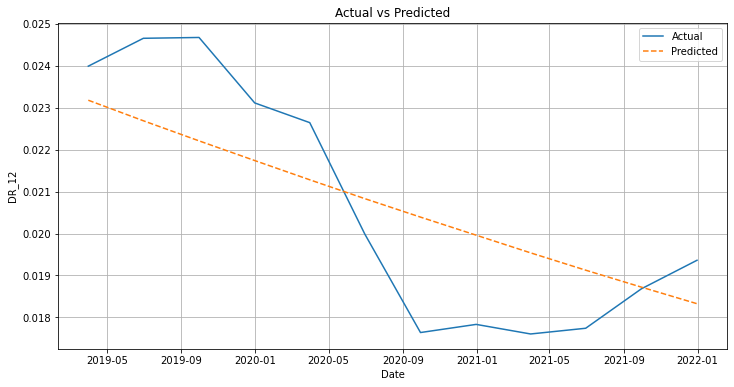

,actual,predicted
2019-03-31,0.023989,0.023178
2019-06-30,0.024654,0.022688
2019-09-30,0.024674,0.022209
2019-12-31,0.023113,0.021740
2020-03-31,0.022643,0.021281
2020-06-30,0.019986,0.020831
2020-09-30,0.017640,0.020391
2020-12-31,0.017834,0.019961
2021-03-31,0.017606,0.019539
2021-06-30,0.017742,0.019126


In [22]:
# Calculate the RMSE
val_rmse = mean_squared_error(validation_data['DR_12'], val_predictions,squared=False)

print("RMSE:",val_rmse)

# Create a dataframe to compare actual and predicted values
compare_df = pd.DataFrame({'actual': validation_data['DR_12'], 'predicted': val_predictions})

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(compare_df['actual'], label='Actual')
plt.plot(compare_df['predicted'], label='Predicted', linestyle='--')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('DR_12')
plt.legend()
plt.grid(True)
plt.show()

# Display the dataframe
compare_df

RMSE has a value of 0.0016802358001827646, which is the best one so far.

The trendline seems to align well with the actuals, with very small errors.

In [23]:
# Display the predictions for the 'DR_12' values in the year 2022
test_predictions

2022-03-31    0.017940
2022-06-30    0.017561
2022-09-30    0.017190
2022-12-31    0.016827
Freq: Q-DEC, Name: predicted_mean, dtype: float64

The SARIMAX model's predictions for the 'DR_12' values in the year 2022 are as follows:

    2022-03-31    0.017940
    2022-06-30    0.017561
    2022-09-30    0.017190
    2022-12-31    0.016827

Next, let's check the sign of the regression coefficients in the model.

In [24]:
# Extract the parameters of the model
params = best_results.params

# Display the parameters
print(params)
print(params.corr)

ar.L1     0.978881
sigma2    0.000043
dtype: float64
<bound method Series.corr of ar.L1     0.978881
sigma2    0.000043
dtype: float64>


The fitted SARIMAX model is a univariate model, meaning it only uses past values of the target variable ('DR_12') to make predictions. Therefore, it does not provide coefficients for other variables like GDP or inflation.

ar.L1 (AutoRegressive term of order 1)
sigma2: (Variance of the error term)

They have a correlation of 0.000043 which is significantly lower than the specified threshold of 70%.

Therefore, I will select this model as the winning one.